In [2]:
!pip install jovian --upgrade --quiet

# Classifying CIFAR100 images using ResNets, Regularization, Data Augmentation and Transfer Learning in PyTorch 

In [3]:
import os
import PIL
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
project_name='course_project'

# Preparing the CIFAR100 Dataset
Let's begin by donwloading the dataset and creating PyTorch datasets to load the data.<br>
The CIFAR-100 dataset contains 50,000 training and 10,000 test images of 20 object classes, along with 100 object subclasses. It is traditional to train on the 100 object subclasses. Each image is an RGB image of size 32x32.

In [5]:
from torchvision.datasets.utils import download_url

#Download the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar100.tgz"
download_url(dataset_url, '.')

#Extract from archive
with tarfile.open('./cifar100.tgz','r:gz') as tar:
  tar.extractall(path='./data')

In [6]:
train_dir = './data/cifar100/train'
train_subs = [folder.path for folder in os.scandir(train_dir) if folder.is_dir()]
train_subs = (sorted(train_subs))
train_subs

['./data/cifar100/train/aquatic_mammals',
 './data/cifar100/train/fish',
 './data/cifar100/train/flowers',
 './data/cifar100/train/food_containers',
 './data/cifar100/train/fruit_and_vegetables',
 './data/cifar100/train/household_electrical_devices',
 './data/cifar100/train/household_furniture',
 './data/cifar100/train/insects',
 './data/cifar100/train/large_carnivores',
 './data/cifar100/train/large_man-made_outdoor_things',
 './data/cifar100/train/large_natural_outdoor_scenes',
 './data/cifar100/train/large_omnivores_and_herbivores',
 './data/cifar100/train/medium_mammals',
 './data/cifar100/train/non-insect_invertebrates',
 './data/cifar100/train/people',
 './data/cifar100/train/reptiles',
 './data/cifar100/train/small_mammals',
 './data/cifar100/train/trees',
 './data/cifar100/train/vehicles_1',
 './data/cifar100/train/vehicles_2']

In [7]:
import shutil
dst = './data/cifar/train'
for src in train_subs:
  for file in os.listdir(src):
    src_file = os.path.join(src, file)
    dst_file = os.path.join(dst, file)
    shutil.move(src_file, dst_file)


In [8]:
dst = './data/cifar/test'
test_dir = './data/cifar100/test'
test_subs = [folder.path for folder in os.scandir(test_dir) if folder.is_dir()]
for src in test_subs:
  for file in os.listdir(src):
    src_file = os.path.join(src, file)
    dst_file = os.path.join(dst, file)
    shutil.move(src_file, dst_file)

In [9]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/husain0007/course-project


'https://jovian.ai/husain0007/course-project'

In [10]:
# Look into the data dirtectory
data_dir = './data/cifar'
print(os.listdir(data_dir))
classes = os.listdir(data_dir+'/train')
print(len(classes))

['train', 'test']
100


Create training and validation datasets using the `ImageFolder` class from `torchvision`.<br>
<ol>
<li>
We will use the test set as our validation set. This just gives us a little more data to train with. </li>
<li> We will normalize the image </tensors by subtracting the mean and dividing by the standard deviation across each channel</li><br>
<li><b>Randomized Image Augmentation</b><br>
   <p>We apply randomly chosen transformations wihle loading images from teh training datasets. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32x32 pixels, and then flip the image horizontally with 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it to generalize better.</p></li>

In [11]:
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
train_tfms = tt.Compose([#tt.Resize((224,224)),
                         tt.RandomCrop(32, padding=4, 
                                       padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(20, 
                          resample=PIL.Image.BILINEAR),
                         tt.ColorJitter(brightness=0.1, contrast=0.1,
                                        saturation=0.1, hue=0.1),
                         tt.ToTensor(),
                         tt.Normalize(*stats, inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [12]:
# PyTorch Datasets
train_ds = ImageFolder(data_dir+ '/train', train_tfms)
valid_ds = ImageFolder(data_dir+ '/test', valid_tfms)

Next we can create data loaders for retrieving images in batches. We'll use a relatively large batch size of 500 to utilize a larger portion of the GPU RAM. Reduce the batch size if "out of memory" error appears.

In [17]:
batch_size = 128

In [18]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers= 4, pin_memory= True)
valid_dl = DataLoader(valid_ds, batch_size*2,  shuffle=True, num_workers=4, pin_memory= True)

Now to take a look at some sample images from the training dataloader we'll need to <i>denormalize</i> the pixel values to bring them back into the range `(0,1)`

In [19]:
def denormalize(images, means, stds):
  means = torch.tensor(means).reshape(1, 3, 1, 1)
  stds = torch.tensor(stds).reshape(1, 3, 1 , 1)
  return images * stds + means

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    denorm_images = denormalize(images, *stats)
    ax.imshow(make_grid(denorm_images[:81], nrow=9).permute(1, 2, 0).clamp(0, 1))
    break # To only load the first grid from the data loader
    

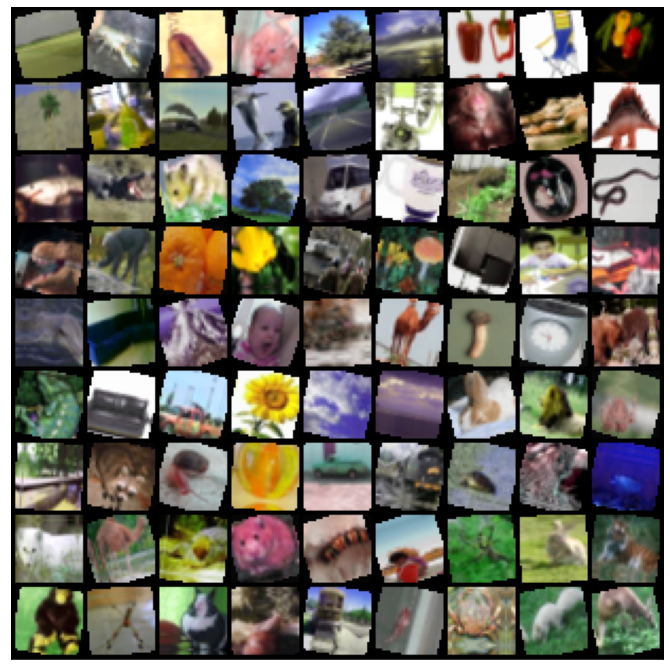

In [20]:
show_batch(train_dl)

<h2> Using a GPU </h2>
To seamlessly use a GPU, if one is available, we define a few helper functions ("get_default_device" & "to_device") and a helper class "DeviceDataLoader" to move the model & data to the GPU as required.



In [21]:
def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  """Move tensor(s) to chose device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [22]:
device = get_default_device()
device

device(type='cuda')

In [23]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# Choose the model

In [30]:
import torchvision.models as models
#ResNet18_pretrained = models.resnet18(pretrained=True)
model = models.resnext50_32x4d(pretrained=True)

In [31]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [32]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

<h3>Adding Dropout layer before the final layer of ResNet34</h3>

In [33]:
class ResNext50(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = model
    self.network.fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(self.network.fc.in_features, 100)
    )
    # num_features = self.network.fc.in_features
    # self.network.fc  = nn.Linear(num_features, 100)

  def forward(self, xb):
    return self.network(xb)

In [34]:
model = to_device(ResNext50(), device)
model
print(batch_size )

128


In [35]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval() # Let's the model know to disable dropout & batch
                 # normalization layer
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [36]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.010449218563735485, 'val_loss': 4.631298065185547}]

In [37]:
#!pip install pytorch-lightning

We're now ready to train our model. We've chosen to use the Adam Optimizer which uses techniques like momentum and adaptive learning rates for faster training. 

In [38]:
epochs = 35 # 8
max_lr = 1e-4 #0.01 #9e-4
grad_clip = 2e-3 #0.1
weight_decay = 1e-5
opt_func = torch.optim.Adam

In [39]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00001, train_loss: 4.6596, val_loss: 4.5711, val_acc: 0.0238
Epoch [1], last_lr: 0.00001, train_loss: 4.4385, val_loss: 4.2407, val_acc: 0.0721
Epoch [2], last_lr: 0.00002, train_loss: 3.8993, val_loss: 3.5427, val_acc: 0.1756
Epoch [3], last_lr: 0.00003, train_loss: 3.2139, val_loss: 2.7608, val_acc: 0.3101
Epoch [4], last_lr: 0.00005, train_loss: 2.6710, val_loss: 2.2332, val_acc: 0.4179
Epoch [5], last_lr: 0.00006, train_loss: 2.3076, val_loss: 1.9298, val_acc: 0.4825
Epoch [6], last_lr: 0.00008, train_loss: 2.0571, val_loss: 1.7677, val_acc: 0.5204
Epoch [7], last_lr: 0.00009, train_loss: 1.8824, val_loss: 1.7625, val_acc: 0.5332
Epoch [8], last_lr: 0.00010, train_loss: 1.7455, val_loss: 1.6963, val_acc: 0.5586
Epoch [9], last_lr: 0.00010, train_loss: 1.6202, val_loss: 1.6228, val_acc: 0.5771
Epoch [10], last_lr: 0.00010, train_loss: 1.5155, val_loss: 1.5453, val_acc: 0.5858
Epoch [11], last_lr: 0.00010, train_loss: 1.4098, val_loss: 1.5176, val_acc: 0.6024
Ep

In [40]:
 train_time = '49:46'

Let's plot the validation set accuracies to study how the model improves over time

In [41]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

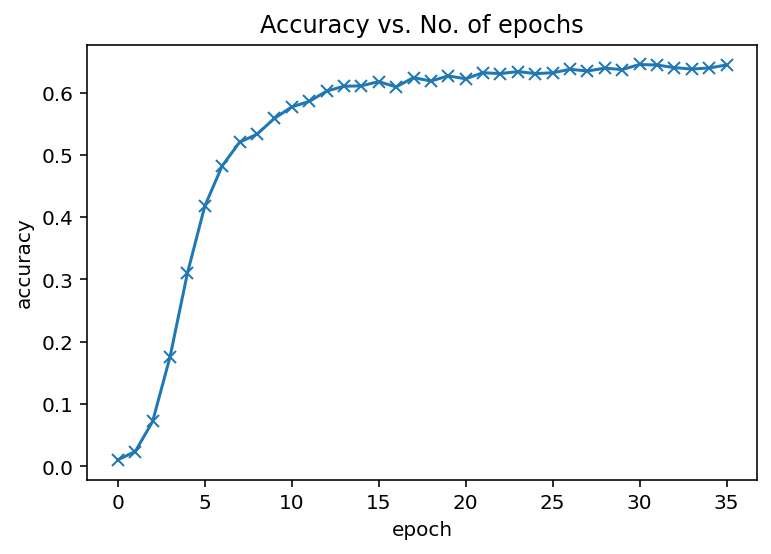

In [42]:
%config InlineBackend.figure_format ='retina'
plot_accuracies(history)

As can be seen, with the application of the ResNext50 Model we were able to make a significant improvement to our model and achieve an accuracy of about `64.44%` accuracy. However, we have not made progress in reducing overfitting. This will be taken up in future versions.

We can also plot the training and validation losses to study the trend.

In [43]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. Number of Epochs');

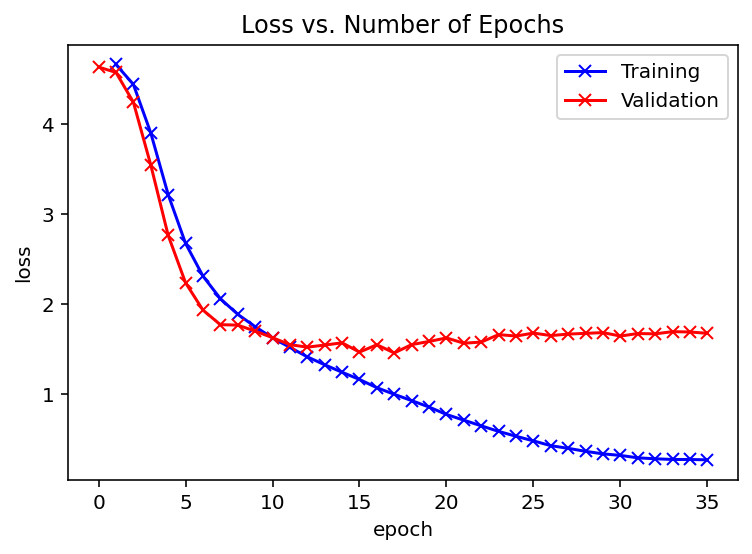

In [44]:
plot_losses(history)

After applying a `Dropout(p=0.3)` there has been a drop in overfitting from a val_loss of <b>1.9</b> to about <b>1.6</b>. We will re-try with larger Dropout in the next version.

In [45]:
def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs',[]) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch Number')
  plt.ylabel('Learning Rate')
  plt.title('Learning Rate vs. Batch Number');

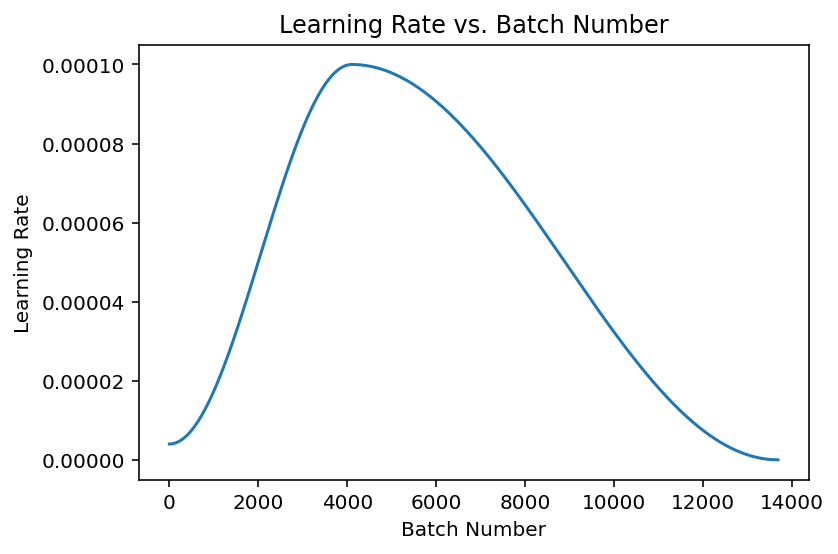

In [46]:
plot_lrs(history)

# Testing with individual images
While we have been tracking the overall accuracy of a model so far, it's a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10,000 images.

In [47]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: apple , Predicted: apple


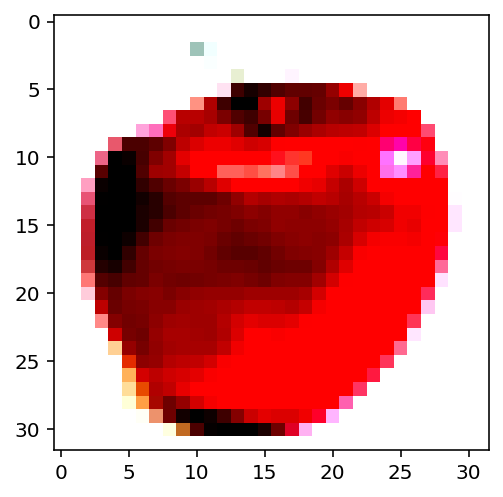

In [48]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: bowl , Predicted: turtle


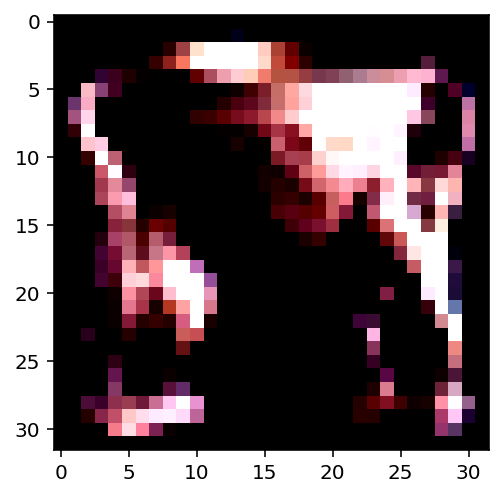

In [49]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: plate , Predicted: plate


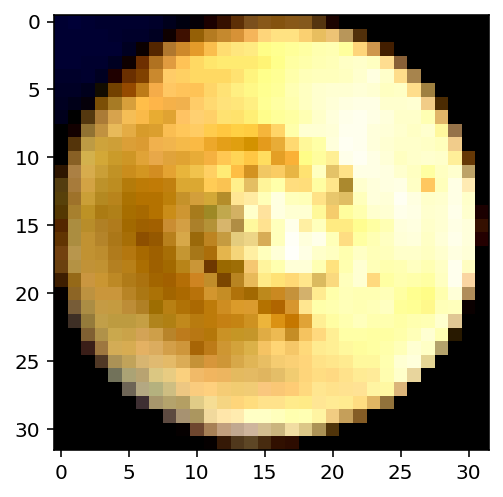

In [50]:
img, label = valid_ds[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: bee , Predicted: bee


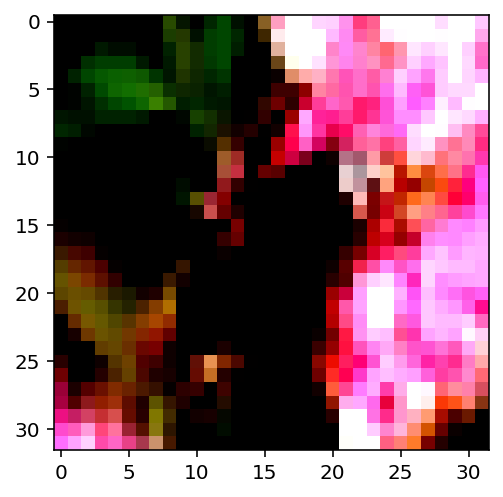

In [51]:
img, label = valid_ds[650]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us to improve the model by collecting more training data,
increasing/decreasing the complexity of the model, and changing the hyperparameters.

## Save and Commit

Let's save the weights of the model, record the hyperparameters, and commit our experiment to Jovian. 

In [52]:
torch.save(model.state_dict(), 'cifar100-resnext50.pth')

In [53]:
!pip install jovian --upgrade --quiet

In [54]:
import jovian

In [55]:
jovian.reset()
jovian.log_hyperparams(arch='resne-pretrained',
                       epochs=epochs,
                       lr=max_lr,
                       scheduler='one-cycle',
                       weight_decay=weight_decay,
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)


[jovian] Hyperparams logged.


In [56]:
jovian.log_metrics(val_loss=history[-1]['val_loss'],
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

[jovian] Metrics logged.


In [57]:
jovian.commit(project=project_name, environment=None, outputs=['cifar100-resnet50.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/husain0007/course-project


'https://jovian.ai/husain0007/course-project'